#Suicide Rates Overview 1985 to 2016
Compares socio-economic info with suicide rates by year and country

###**Content**

This compiled dataset pulled from four other datasets linked by time and place, and was built to find signals correlated to increased suicide rates among different cohorts globally, across the socio-economic spectrum.

###**References**

United Nations Development Program. (2018). Human development index (HDI). Retrieved from http://hdr.undp.org/en/indicators/137506

World Bank. (2018). World development indicators: GDP (current US$) by country:1985 to 2016. Retrieved from http://databank.worldbank.org/data/source/world-development-indicators#

[Szamil]. (2017). Suicide in the Twenty-First Century [dataset]. Retrieved from https://www.kaggle.com/szamil/suicide-in-the-twenty-first-century/notebook

World Health Organization. (2018). Suicide prevention. Retrieved from http://www.who.int/mental_health/suicide-prevention/en/

# Preliminaries

In [1]:
! pip install pycountry
! pip install pycountry_convert
! pip install folium
! pip install geopandas

     |████████████████████████████████| 10.1MB 5.2MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746863 sha256=d69129c51ffc4da3f5f430450065f9fc47e70604d242b01f0bc40159b05874e8
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry
     |████████████████████████████████| 245kB 5.8MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 5.4 which is incompatible.
ERROR: pytest-cov 2.11.1 has requirement pytest>=4.6, but you'll have pytest 3.6.4 which is incompatible.
ERROR: pytest-mock 3.5.1 has requirement pytest>=5.0, but you'll have pytest 3.6.4 which is incompatible.
  Found existing installation: coverage 3.7.1


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import pycountry
import pycountry_convert as pc
import geopandas as gpd
from scipy.stats import linregress
import folium
plt.style.use('seaborn')

# Get the data
Run the following two cells below to get the data for this EDA.

Note: after getting the data we are changing the titles of the columns. 



In [3]:
pd.options.display.max_rows = 60
pd.options.display.min_rows = 20

In [4]:
url = 'https://raw.githubusercontent.com/danihello/suicides_eda/main/master.csv'

resp = requests.get(url)
text = resp.text

with open('master.csv', 'w') as fh:
    fh.write(text)
  
suicide_df = pd.read_csv('master.csv')

suicide_df.columns = suicide_df.columns.str.lower().str.strip()
suicide_df.rename(columns={'suicides/100k pop':'suicides_per_100k_capita',
                               'hdi for year':'hdi',
                               'gdp_for_year ($)':'gdp',
                               'gdp_per_capita ($)':'gdp_per_capita'}, inplace=True)

# Data inspection

***Dataset Structure***

- Country - dataset contains 101 unique countries in varying continents (we exclude 15 countries due to lack of observations year wise).
- Years - 1985 - 2016 (we exclude 2016 in the datacleaning phase due to lack of observations).
- Sex - male and female.
- Age - The age variable has 6 cohorts of age: 5-14, 15-24, 25-34, 35-54, 55-74, 75+).
- Suicides_no - total number of suicides by country, age, sex, year.
- Population - total population by country, age, sex, year.
- Suicides_per_100k_capita - Suicides_no / (Population/100,000).
- Country-year - concatenation of country and year, we didnt use it for our analysis. So we dropped it.
- HDI - Human Development Index. about 70% of its data is missing, we decided not to use it for our analysis (lack of information).
- Gdp - Gross Domestic Product. indicates a countries size of economy by country, age, sex, year.
- Gdp_per_capita - GDP/Population - indicates a countries well being wealth.
- Generation - The generation has 6 categories: Generation X, Silent, G.I. Generation, Boomers, Millenials, Generation Z. 

In [5]:
suicide_df.head(5)

,country,year,sex,age,suicides_no,population,suicides_per_100k_capita,country-year,hdi,gdp,gdp_per_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [6]:
suicide_df.tail(5)

,country,year,sex,age,suicides_no,population,suicides_per_100k_capita,country-year,hdi,gdp,gdp_per_capita,generation
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27819,Uzbekistan,2014,female,55-74 years,21,1438935,1.46,Uzbekistan2014,0.675,"63,067,077,179",2309,Boomers


In [7]:
suicide_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country                   27820 non-null  object 
 1   year                      27820 non-null  int64  
 2   sex                       27820 non-null  object 
 3   age                       27820 non-null  object 
 4   suicides_no               27820 non-null  int64  
 5   population                27820 non-null  int64  
 6   suicides_per_100k_capita  27820 non-null  float64
 7   country-year              27820 non-null  object 
 8   hdi                       8364 non-null   float64
 9   gdp                       27820 non-null  object 
 10  gdp_per_capita            27820 non-null  int64  
 11  generation                27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [8]:
suicide_df.describe(include='O').T

,count,unique,top,freq
country,27820,101,Iceland,382
sex,27820,2,male,13910
age,27820,6,25-34 years,4642
country-year,27820,2321,Bulgaria2000,12
gdp,27820,2321,"1,573,670,250",12
generation,27820,6,Generation X,6408


In [9]:
pd.options.display.float_format = '{:,.2f}'.format
suicide_df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,"27,820.00","2,001.26",8.47,"1,985.00","1,995.00","2,002.00","2,008.00","2,016.00"
suicides_no,"27,820.00",242.57,902.05,0.00,3.00,25.00,131.00,"22,338.00"
population,"27,820.00","1,844,793.62","3,911,779.44",278.00,"97,498.50","430,150.00","1,486,143.25","43,805,214.00"
suicides_per_100k_capita,"27,820.00",12.82,18.96,0.00,0.92,5.99,16.62,224.97
hdi,"8,364.00",0.78,0.09,0.48,0.71,0.78,0.85,0.94
gdp_per_capita,"27,820.00","16,866.46","18,887.58",251.00,"3,447.00","9,372.00","24,874.00","126,352.00"


# Data cleaning

## Exploring the data before cleanup phase

### HDI

In [10]:
suicide_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country                   27820 non-null  object 
 1   year                      27820 non-null  int64  
 2   sex                       27820 non-null  object 
 3   age                       27820 non-null  object 
 4   suicides_no               27820 non-null  int64  
 5   population                27820 non-null  int64  
 6   suicides_per_100k_capita  27820 non-null  float64
 7   country-year              27820 non-null  object 
 8   hdi                       8364 non-null   float64
 9   gdp                       27820 non-null  object 
 10  gdp_per_capita            27820 non-null  int64  
 11  generation                27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [11]:
suicide_df.hdi.notna().sum()/suicide_df.hdi.shape[0]

0.30064701653486703

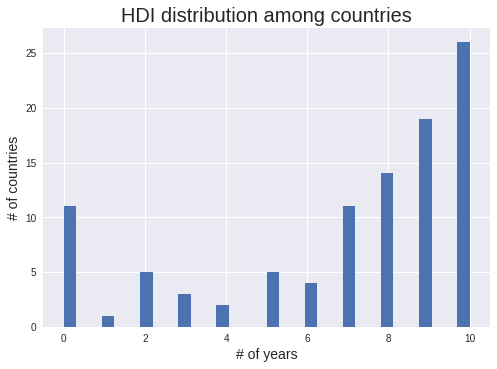

In [12]:
pd.crosstab(suicide_df.country, suicide_df.year, values=suicide_df.hdi, aggfunc='count').fillna(0).applymap(lambda val:1 if val>0 else 0).sum(axis=1).hist(bins=32)
plt.xlabel('# of years', fontsize=14)
plt.ylabel('# of countries', fontsize=14)
plt.title('HDI distribution among countries',fontsize=20)
plt.show()

***Conclusions:***


*   **hdi** is missing **70%** of the data for this columns.
*   hdi is missing **consistently** in all of the countries (only **25** out of **101** countries have **10** years of data out of **32** possible).



### Country

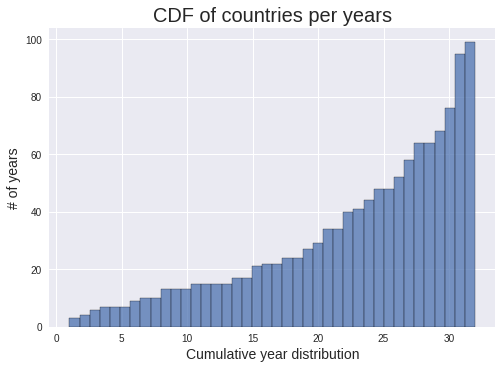

In [13]:
df_country_messy = suicide_df.groupby(['year','country','country-year'])[['population','suicides_no']].sum().apply(lambda year:year.suicides_no/(year.population/100000), axis=1)\
.to_frame().rename(columns={0:'suicides_per_100k_capita'}).reset_index()

df_zero = df_country_messy.loc[df_country_messy.suicides_per_100k_capita==0]
suicide_df = suicide_df.loc[~suicide_df['country-year'].isin(df_zero['country-year'])]

countries_by_year = pd.crosstab(suicide_df.country, suicide_df.year).applymap(lambda val:1 if val>0 else 0).sum(axis=1)#.hist(bins=32, density=True, cumulative=1)
sns.histplot(data=countries_by_year, bins=40, cumulative=True)
plt.ylabel('# of years', fontsize=14)
plt.xlabel('Cumulative year distribution', fontsize=14)
plt.title('CDF of countries per years', fontsize=20)
plt.show()

***Conclusions***


*   **86** out of **101** countries have at least **10+ years** of data (around **86% of countries** in the sample).
*   we exclude a combination of **country and year** in case the overall suicide count **equals to zero**




### Years

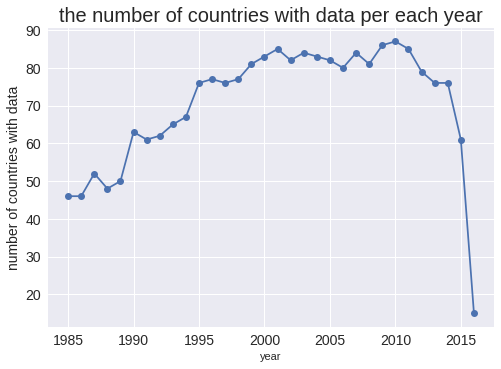

In [14]:
pd.crosstab(suicide_df.year,suicide_df.country).applymap(lambda val:1 if val>0 else 0).sum(axis=1).plot(marker='o', fontsize=14)
plt.ylabel('number of countries with data',fontsize=14)
plt.title('the number of countries with data per each year', fontsize=20)
plt.show()

***Conclusions***


*   Only 15 countries out of 101 (15% of data) have data in 2016.
*   The 80's have a relativly low representation of countries. 



### Sex & Age

we are checking to see if a certain age group or a certain sex has alot of missing data

In [15]:
pd.crosstab(suicide_df.age,suicide_df.sex).apply(lambda grp:grp.female -grp.male, axis=1).sum()

0

In [16]:
pd.crosstab(suicide_df.year, suicide_df.age).T

year,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
age,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15-24 years,92,92,104,96,100,126,122,124,130,134,152,154,152,154,162,166,170,164,168,166,164,160,168,162,172,174,170,158,152,152,122,30
25-34 years,92,92,104,96,100,126,122,124,130,134,152,154,152,154,162,166,170,164,168,166,164,160,168,162,172,174,170,158,152,152,122,30
35-54 years,92,92,104,96,100,126,122,124,130,134,152,154,152,154,162,166,170,164,168,166,164,160,168,162,172,174,170,158,152,152,122,30
5-14 years,92,92,104,96,100,126,122,124,130,134,152,154,152,154,162,166,170,164,168,166,164,160,168,162,172,174,170,158,152,152,122,0
55-74 years,92,92,104,96,100,126,122,124,130,134,152,154,152,154,162,166,170,164,168,166,164,160,168,162,172,174,170,158,152,152,122,30
75+ years,92,92,104,96,100,126,122,124,130,134,152,154,152,154,162,166,170,164,168,166,164,160,168,162,172,174,170,158,152,152,122,30


In [17]:
(pd.crosstab(suicide_df.country, suicide_df.sex).male != pd.crosstab(suicide_df.country, suicide_df.sex).female).sum()

0


***Conclusions***


*   There is an equal reperentation of ages across both sexes and across all years (no missing data).
* Sex data is apperant for both sexes across countries (again no missing data for sexes).

### Generation

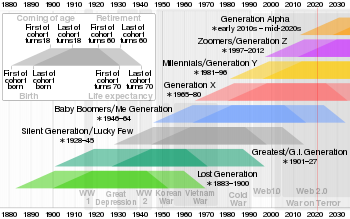

[Generation description](https://en.wikipedia.org/wiki/Generation#/media/File:Generation_timeline.svg)

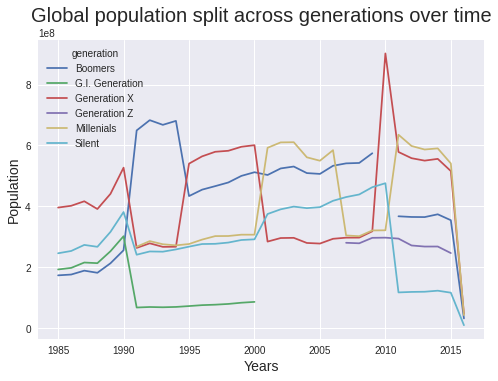

In [18]:
pd.crosstab(suicide_df.year, suicide_df.generation, values=suicide_df.population, aggfunc='sum', dropna=True).plot()
plt.title('Global population split across generations over time', fontsize=20, y=1.04)
plt.ylabel('Population', fontsize=14)
plt.xlabel('Years', fontsize=14)
plt.show()

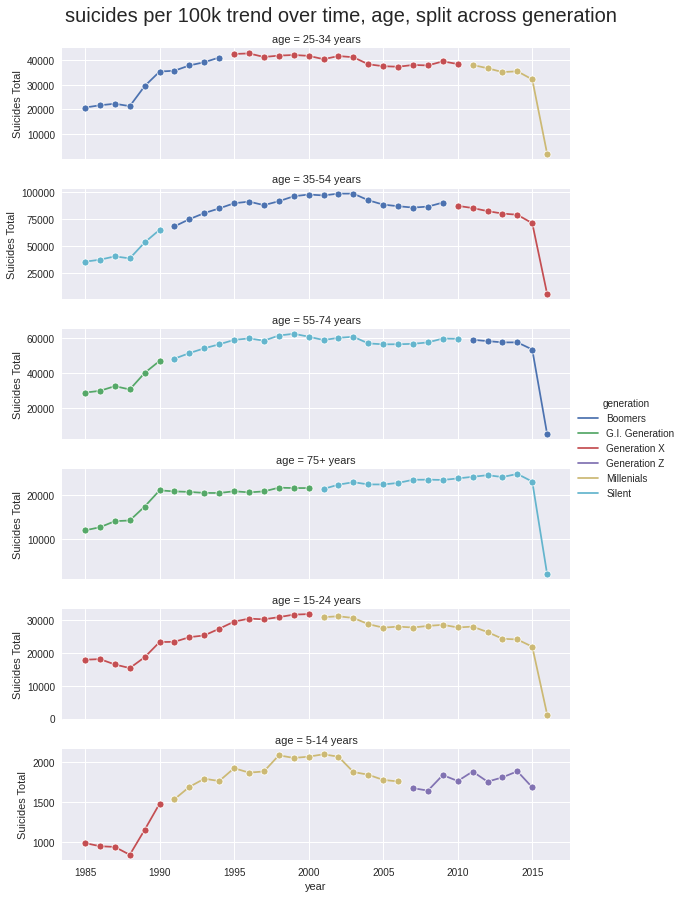

In [19]:
age_gen_year = suicide_df.groupby(['generation', 'age','year']).suicides_no.sum().unstack().reset_index(['generation', 'age'])
g = sns.relplot(data=age_gen_year.melt(id_vars=['generation','age'], var_name='year'),
            row='age', x='year', y='value', hue='generation', height=2, kind='line', facet_kws={'sharey':False, 'sharex':True},
            aspect=4, marker='o')
 
for ax in g.axes.flat:
    ax.set_ylabel('Suicides Total')

plt.suptitle('suicides per 100k trend over time, age, split across generation', y=1.02, fontsize=20)
plt.show()

***Conclusions***



*   The first figure demonstrates **large spikes** and drops per generation's population in a year which age bands begin/stop being classified as a certain generation.
*   This shouldn't be possible, because **not everyone in a given age cohort & year will be of one generation**
the second figure demonstrates this well as after a certain year all ages switch to a different generation.

*   **Due to this we conclude that using this variable might lead to some wrong conclusions**.



---







***Based on the analysis above, we did the following cleanup actions:***


*   GDP: convert from object(string) to integer.
*   year: dropped 2016. Only 15 countries have data for 2016, it is too much of a small sample size, so we remove it entirely.
*   country: there are 15 countries with less then 10 years of data, this sample size is to low for our analysis so we remove them.
*   hdi: we decided to drop this column entierly since it has it holds valid data at only 30% of the all dataset (rest are nulls).
*   Country-year: as mentioned before it has no new data and is a combination of country and year.
*   generation: we exclude it due to reasonds which were explained priorly.






In [20]:
suicide_df.gdp = suicide_df.gdp.str.replace(',','').astype('int')
suicide_df = suicide_df.loc[suicide_df.year!=2016]
suicide_df['year_n'] = suicide_df.groupby('country').year.transform(lambda grp:grp.nunique())
year_n = 10
suicide_df = suicide_df.loc[suicide_df.year_n >= year_n]
keep_columns = ['country', 'year', 'sex', 'age', 'suicides_no', 'population', 'suicides_per_100k_capita', 'gdp', 'gdp_per_capita']
suicide_df = suicide_df.loc[:, keep_columns]
age_cat = pd.CategoricalDtype(['5-14 years','15-24 years','25-34 years','35-54 years','55-74 years','75+ years'], ordered=True)

# setting age as ordered categorical variable
suicide_df.age = suicide_df.age.astype(age_cat)

In [21]:
suicide_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26208 entries, 0 to 27819
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   country                   26208 non-null  object  
 1   year                      26208 non-null  int64   
 2   sex                       26208 non-null  object  
 3   age                       26208 non-null  category
 4   suicides_no               26208 non-null  int64   
 5   population                26208 non-null  int64   
 6   suicides_per_100k_capita  26208 non-null  float64 
 7   gdp                       26208 non-null  int64   
 8   gdp_per_capita            26208 non-null  int64   
dtypes: category(1), float64(1), int64(5), object(2)
memory usage: 1.8+ MB


*After* the cleaning phase our overall raw size dropped from 27820 to 26208

In [22]:
suicide_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,26208,86,Chile,372,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,"26,208.00",NaN,NaN,NaN,"2,001.06",8.42,"1,985.00","1,994.00","2,001.00","2,008.00","2,015.00"
sex,26208,2,male,13104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,26208,6,75+ years,4368,NaN,NaN,NaN,NaN,NaN,NaN,NaN
suicides_no,"26,208.00",NaN,NaN,NaN,256.37,927.44,0.00,4.00,29.00,144.00,"22,338.00"
population,"26,208.00",NaN,NaN,NaN,"1,930,047.01","3,997,878.91",500.00,"131,374.00","476,077.00","1,624,217.00","43,805,214.00"
suicides_per_100k_capita,"26,208.00",NaN,NaN,NaN,13.38,19.21,0.00,1.26,6.56,17.40,224.97
gdp,"26,208.00",NaN,NaN,NaN,"468,204,258,426.47","1,493,825,764,308.36","145,641,704.00","10,813,984,883.50","53,243,390,517.00","271,167,609,907.75","18,120,714,000,000.00"
gdp_per_capita,"26,208.00",NaN,NaN,NaN,"17,159.19","19,126.14",251.00,"3,435.75","9,484.00","25,594.00","126,352.00"


# Data enrichment

We add the continent for each country using pycountry and pycountry_convert.

In [23]:
def country_to_continent(country):
    """recives a country name and returns the continent of that country
    """
    country = country.lower()
    try:
        country_code = pycountry.countries.search_fuzzy(country)[0].alpha_2
    except LookupError:
        country = country.split('and')[0]
    try:
        country_code = pycountry.countries.search_fuzzy(country)[0].alpha_2
        continent_code = pc.country_alpha2_to_continent_code(country_code)
    except:
        return 'Unknown'
    return pc.convert_continent_code_to_continent_name(continent_code)

country_continent_dict = pd.DataFrame(suicide_df.country.unique(), columns=['country'])
country_continent_dict['continent'] = country_continent_dict.country.apply(country_to_continent)
country_continent_dict.continent.value_counts()


Europe           35
North America    18
Asia             18
South America     9
Africa            3
Oceania           3
Name: continent, dtype: int64

In [24]:
suicide_df = suicide_df.merge(country_continent_dict, how='inner', on='country')
suicide_df.head(5)

,country,year,sex,age,suicides_no,population,suicides_per_100k_capita,gdp,gdp_per_capita,continent
0,Albania,1987,male,15-24 years,21,312900,6.71,2156624900,796,Europe
1,Albania,1987,male,35-54 years,16,308000,5.19,2156624900,796,Europe
2,Albania,1987,female,15-24 years,14,289700,4.83,2156624900,796,Europe
3,Albania,1987,male,75+ years,1,21800,4.59,2156624900,796,Europe
4,Albania,1987,male,25-34 years,9,274300,3.28,2156624900,796,Europe


In [25]:
suicide_df.tail(5)

,country,year,sex,age,suicides_no,population,suicides_per_100k_capita,gdp,gdp_per_capita,continent
26203,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,63067077179,2309,Asia
26204,Uzbekistan,2014,female,75+ years,9,348465,2.58,63067077179,2309,Asia
26205,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,63067077179,2309,Asia
26206,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,63067077179,2309,Asia
26207,Uzbekistan,2014,female,55-74 years,21,1438935,1.46,63067077179,2309,Asia


In [26]:
suicide_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26208 entries, 0 to 26207
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   country                   26208 non-null  object  
 1   year                      26208 non-null  int64   
 2   sex                       26208 non-null  object  
 3   age                       26208 non-null  category
 4   suicides_no               26208 non-null  int64   
 5   population                26208 non-null  int64   
 6   suicides_per_100k_capita  26208 non-null  float64 
 7   gdp                       26208 non-null  int64   
 8   gdp_per_capita            26208 non-null  int64   
 9   continent                 26208 non-null  object  
dtypes: category(1), float64(1), int64(5), object(3)
memory usage: 2.0+ MB


***End of cleaning phase***


Our final dataset includes: 

**the following measures:** 

*   total population
*   total suicides
*   total gdp
*   suicides per 100k capita
*   gdp per capita

**the data is calculated per the following segments:**

*   86 different countries
*   6 continents: South and North America, Europe, Africa, Asia, Oceania
*   31 years of data (1985 - 2015)
*   Males and Females
*   6 different age groups: 5-14, 15-24, 25-34, 35-54, 55-74, 75+


#Suicide analysis


## By time trend - Question: How did the global suicide rate changed over 1985 - 2015?

In [ ]:
pd.crosstab(suicide_df.year,suicide_df.country).applymap(lambda val:1 if val>0 else 0).sum(axis=1).plot(marker='o')
plt.ylabel('number of countries with data', fontsize=14)
plt.title('the number of countries with data per year', fontsize=20)
plt.xlabel('Years', fontsize=14)
plt.show()

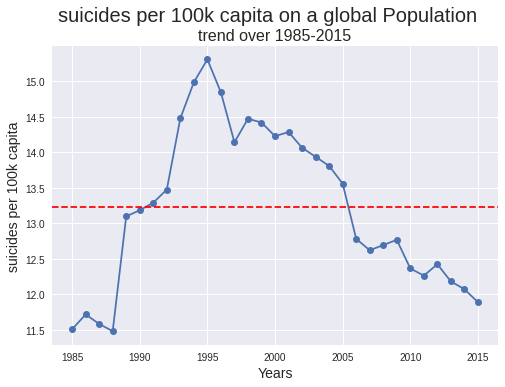

In [28]:
suicides_per_year = suicide_df.groupby('year')[['population', 'suicides_no']].sum().apply(lambda year: year.suicides_no/(year.population/100000), axis=1)
suicides_per_year.plot(marker='o')
plt.axhline(suicides_per_year.mean(), linestyle='--', color='red')
plt.ylabel('suicides per 100k capita', fontsize=14)
plt.title('trend over 1985-2015', fontsize=16)
plt.suptitle('suicides per 100k capita on a global Population', fontsize=20)
plt.xlabel('Years', fontsize=14)
plt.show()

***Insights***



*   peak suicide rate was **15.3** deaths per 100k capita in **1995**.
*   suicide rate in decreasing steadily, to **11.9** per 100k in **2015** (~**22% decrease**).
*   suicide rate only now returns to late 80's.
*   **limited data in the 80's**, it's hard to tell if the suicide rate truly represents the global population.



## By continent - Question: How is the global suicide rate differes between the continents?

In [29]:
continent_palette = {'Africa':'red', 'Asia':'green', 'Europe':'purple', 'North America':'blue', 'Oceania':'teal', 'South America':'orange'}

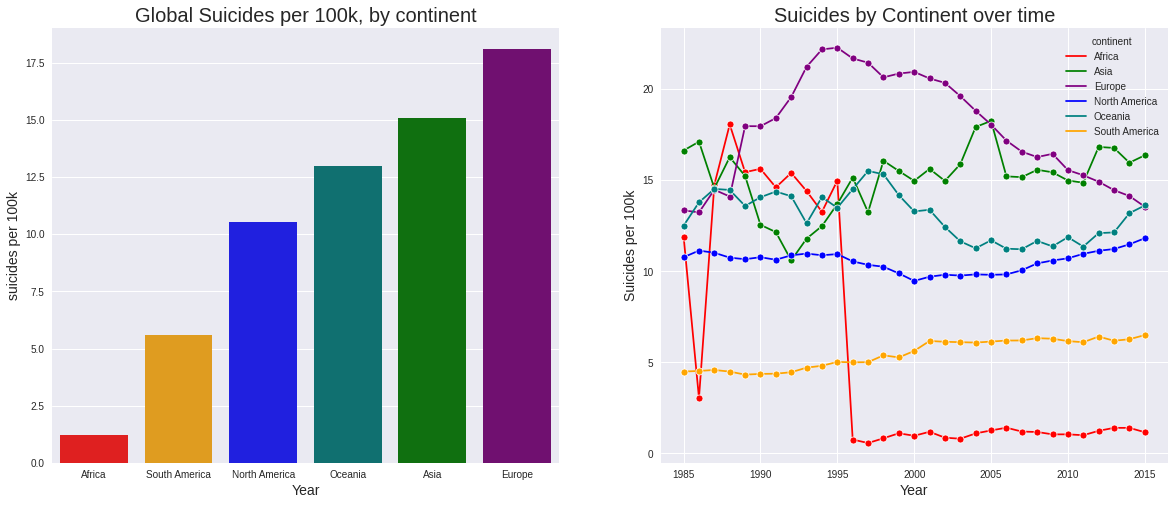

In [30]:
plt.figure(figsize=(20,8))
suicide_by_continent = suicide_df.groupby('continent')[['population', 'suicides_no']].sum().apply(lambda cont: cont.suicides_no/(cont.population/100000), axis=1).sort_values()
suicide_by_continent = suicide_by_continent.to_frame()
suicide_by_continent = suicide_by_continent.rename(columns={0:'suicide_per_capita'})
plt.subplot(1,2,1)
sns.barplot(data=suicide_by_continent, x=suicide_by_continent.index, y='suicide_per_capita', palette=continent_palette)
plt.ylabel('suicides per 100k', fontsize=14)
plt.title('Global Suicides per 100k, by continent', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.subplot(1,2,2)
suicide_year_continent = suicide_df.groupby(['year','continent'])[['population', 'suicides_no']].sum().apply(lambda cont: cont.suicides_no/(cont.population/100000), axis=1).reset_index(-1)
suicide_year_continent
sns.lineplot(data=suicide_year_continent, x=suicide_year_continent.index, y=0, marker='o', hue='continent', palette=continent_palette)
plt.ylabel('Suicides per 100k', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.title('Suicides by Continent over time', fontsize=20)
plt.show()

***Insights***
*   **Europe** has the higest average suicide rate (**18.1** per 100k capita).
*   In **2015,** **Europe** and **Oceania** have the same suicidal rate, while **Asia has the highest suicidal rate out of all continents (16.4 per 100k capita)**.


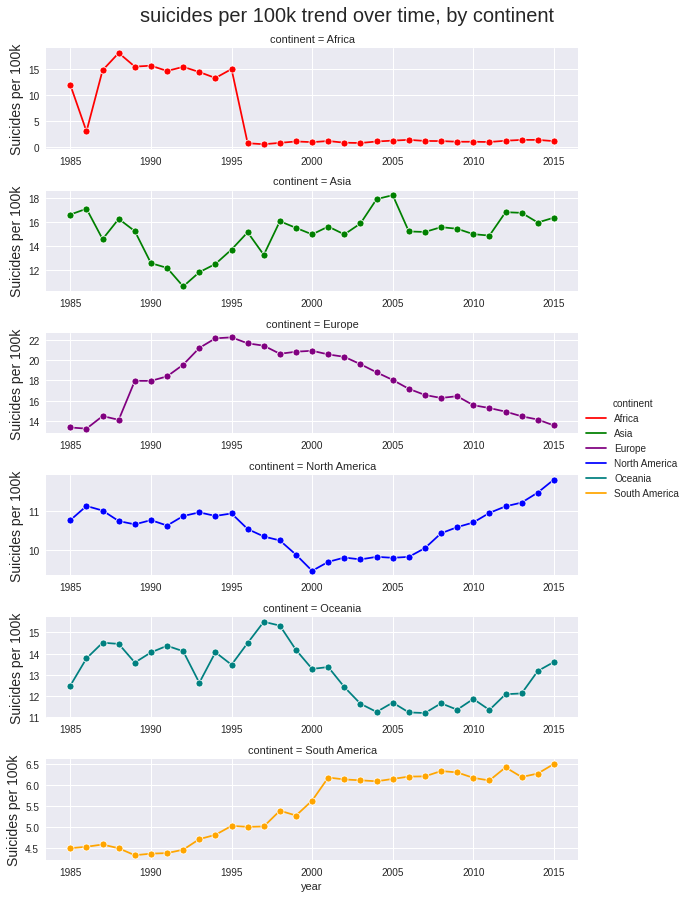

In [31]:
suicide_year_continent = suicide_df.groupby(['year','continent'])[['population', 'suicides_no']].sum().apply(lambda cont: cont.suicides_no/(cont.population/100000), axis=1).reset_index(-1)
g = sns.relplot(data=suicide_year_continent, row='continent', x=suicide_year_continent.index, y=0, height=2, kind='line', facet_kws={'sharey':False, 'sharex':False},
            aspect=4, marker='o', hue='continent', palette=continent_palette)
for ax in g.axes.flat:
    ax.set_ylabel('Suicides per 100k', fontsize=14)

plt.suptitle('suicides per 100k trend over time, by continent', y=1.02, fontsize=20)
plt.show()

***Insights***



*   **Europe's** suicide rate decrease steadily from **1995** (**22.3** per 100k capita) till **2015** (**13.5** per 100k capita), **~39.5% decrease**.
*   Africa's low suicide rate is due to poor data quality - just 3 countries have data.

*   In the mid 2010's **Asia, America and Oceania** present a steady **increase** in suicidal rate over time.



## By Age - Question: Does the Suicide rate increase or decrease with age?

In [32]:
age_palette = {'5-14 years':'red', '15-24 years':'green', '25-34 years':'purple', '35-54 years':'blue', '55-74 years':'teal', '75+ years':'orange'}

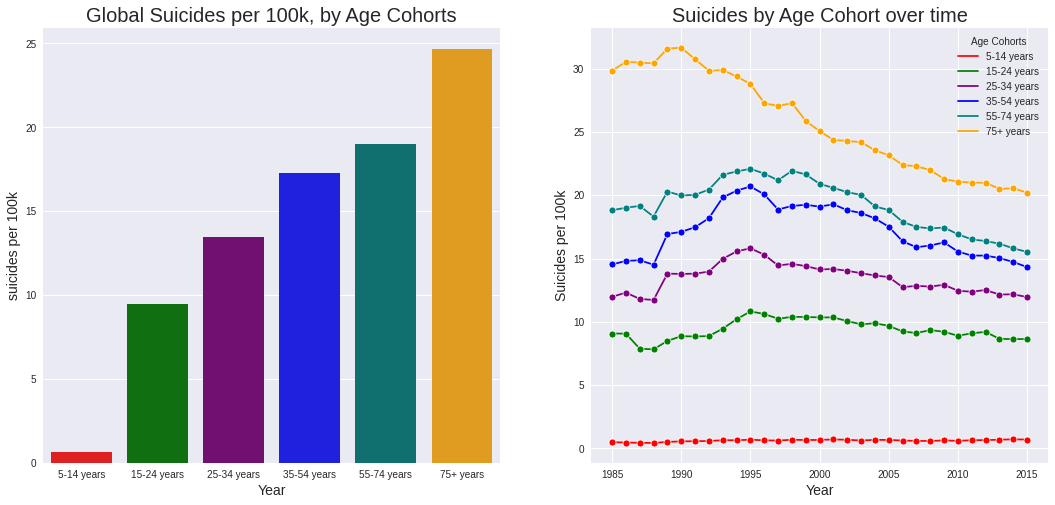

In [33]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
suicide_by_age = suicide_df.groupby('age')[['population', 'suicides_no']].sum().apply(lambda cont: cont.suicides_no/(cont.population/100000), axis=1).sort_values()
suicide_by_age = suicide_by_age.to_frame()
suicide_by_age = suicide_by_age.rename(columns={0:'suicide_per_capita'})
sns.barplot(data=suicide_by_age, x=suicide_by_age.index, y='suicide_per_capita', palette=age_palette)
plt.ylabel('suicides per 100k', fontsize=14)
plt.title('Global Suicides per 100k, by Age Cohorts', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.subplot(1,2,2)
suicide_year_age = suicide_df.groupby(['year','age'])[['population', 'suicides_no']].sum().apply(lambda cont: cont.suicides_no/(cont.population/100000), axis=1).reset_index(-1)
suicide_year_age
sns.lineplot(data=suicide_year_age, x=suicide_year_continent.index, y=0, marker='o', hue='age', palette=age_palette)
plt.ylabel('Suicides per 100k', fontsize= 14)
plt.xlabel('Year', fontsize=14)
plt.title('Suicides by Age Cohort over time', fontsize=20)
plt.legend(title='Age Cohorts')#, bbox_to_anchor=(0.8, -0.2), loc='lower center')
plt.show()

***Insights***



*   The likelihood of suicide increases with age.
*   since **1995** the suicide rate has been **steadily decreasing over time for ages 15+**.
*   suicide rate for **ages 75+** has **decreased** from **30** per 100k capita to **20** per capita **(a 33% decrease)**.
*   Suicide rate for **ages 5-14** remains quite static and **small** (**<1 per 100k per capita**)


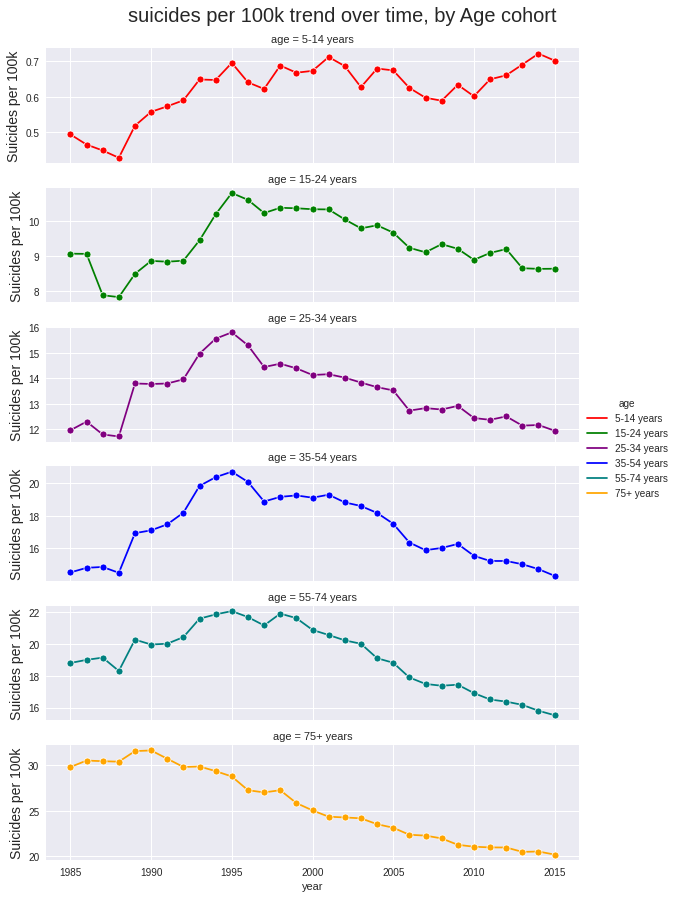

In [34]:
suicide_year_age = suicide_df.groupby(['year','age'])[['population', 'suicides_no']].sum().apply(lambda cont: cont.suicides_no/(cont.population/100000), axis=1).reset_index(-1)
g = sns.relplot(data=suicide_year_age, row='age', x=suicide_year_age.index, y=0, height=2, kind='line', facet_kws={'sharey':False, 'sharex':True},
            aspect=4, marker='o', hue='age', palette=age_palette)
for ax in g.axes.flat:
    
    ax.set_ylabel('Suicides per 100k', fontsize=14)

plt.suptitle('suicides per 100k trend over time, by Age cohort', y=1.02, fontsize=20)
plt.show()

## By Sex - Question: Who commits more suicides? Males or Females?

In [35]:
sex_palette = {'female': 'red', 'male':'blue'}

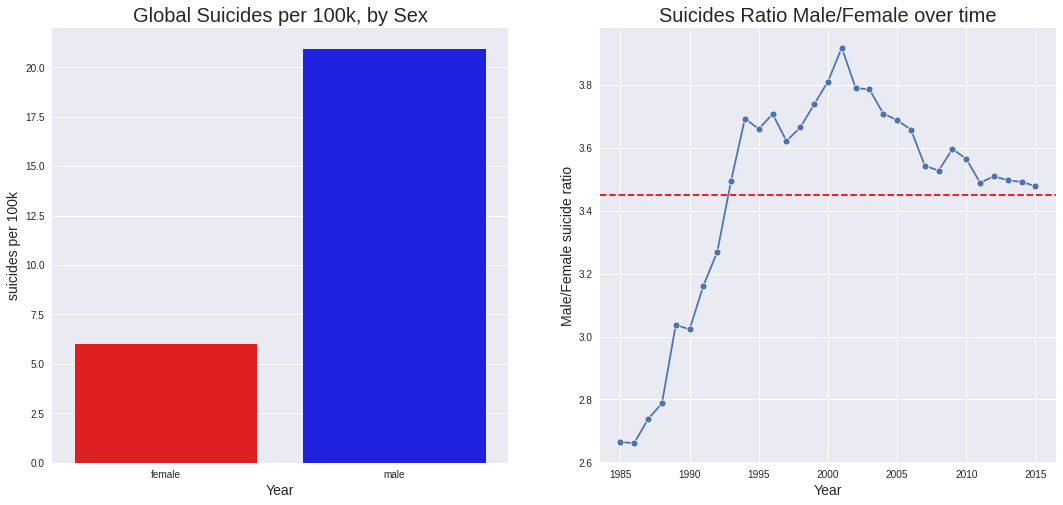

In [36]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
suicide_by_sex = suicide_df.groupby('sex')[['population', 'suicides_no']].sum().apply(lambda cont: cont.suicides_no/(cont.population/100000), axis=1).sort_values()
suicide_by_sex = suicide_by_sex.to_frame()
suicide_by_sex = suicide_by_sex.rename(columns={0:'suicide_per_capita'})
sns.barplot(data=suicide_by_sex, x=suicide_by_sex.index, y='suicide_per_capita', palette=sex_palette)
plt.ylabel('suicides per 100k', fontsize=14)
plt.title('Global Suicides per 100k, by Sex', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.subplot(1,2,2)
suicide_year_sex = suicide_df.groupby(['year','sex'])[['population', 'suicides_no']].sum().apply(lambda cont: cont.suicides_no/(cont.population/100000), axis=1)
suicide_sex_ratio = suicide_year_sex.unstack().apply(lambda year:year.male / year.female, axis=1)
suicide_sex_ratio.name = 'male to female suicide ratio'
sns.lineplot(data=suicide_sex_ratio, marker='o')
plt.axhline(suicide_sex_ratio.mean(), linestyle='--', color='red')
plt.ylabel('Male/Female suicide ratio', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.title('Suicides Ratio Male/Female over time', fontsize=20)
plt.show()

***Insights***

*   The **male** suicide rate is **roughly 3.5x higer** then the **famle** suicide rate.
*   The **male/female ratio** peaked to **3.9** in **2001** and has been steadily decreasing since then.
*   This ratio was as **low** as **2.6 in 1985-1986**.

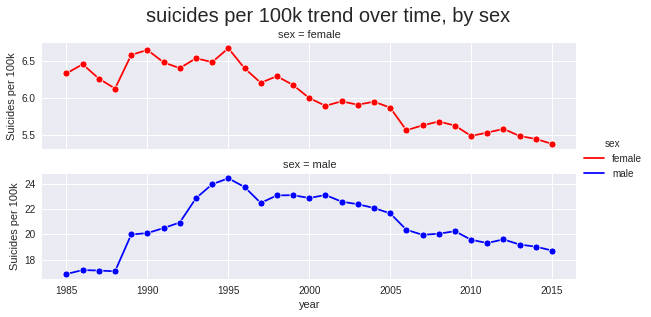

In [37]:
suicide_year_sex = suicide_df.groupby(['year','sex'])[['population', 'suicides_no']].sum().apply(lambda cont: cont.suicides_no/(cont.population/100000), axis=1).reset_index(-1)
g = sns.relplot(data=suicide_year_sex, row='sex', x=suicide_year_sex.index, y=0, height=2, kind='line', facet_kws={'sharey':False, 'sharex':True},
            aspect=4, marker='o', hue='sex', palette=sex_palette)
for ax in g.axes.flat:
    ax.set_ylabel('Suicides per 100k')

plt.suptitle('suicides per 100k trend over time, by sex', y=1.04, fontsize=20)
plt.show()

***Insights***

*   since **1995** the suicide rate has been **steadily decreasing over time for both sexes**.


## By Age and Sex - Question: Ok, so males commits more suicides but is it the same ratio when we control for age?

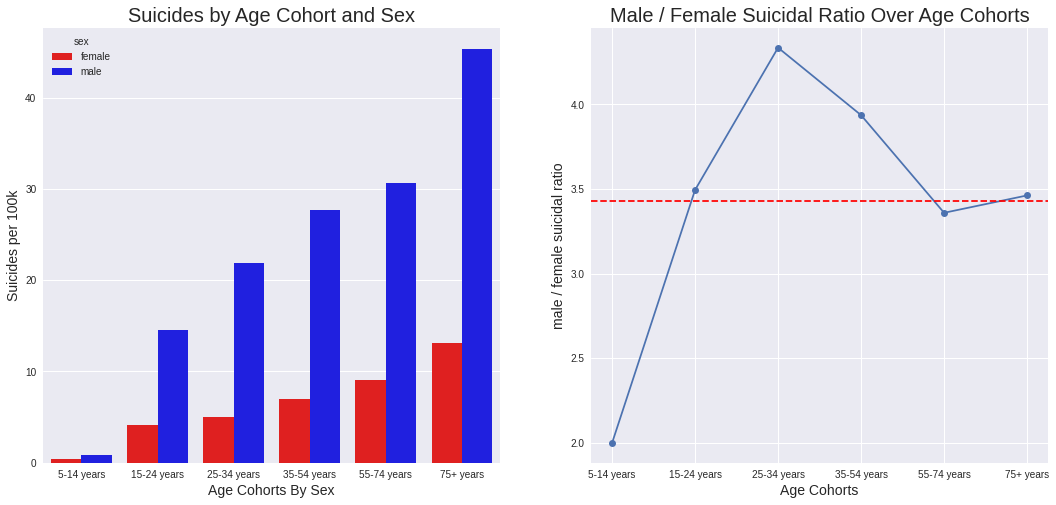

In [38]:
plt.figure(figsize=(18,8))
suicide_age_sex = suicide_df.groupby(['age','sex'])[['population', 'suicides_no']].sum().apply(lambda cont: cont.suicides_no/(cont.population/100000), axis=1).reset_index('sex')
suicide_age_sex
plt.subplot(1,2,1)
sns.barplot(data=suicide_age_sex ,x=suicide_age_sex.index, y=0,hue='sex', palette=sex_palette)
plt.ylabel('Suicides per 100k', fontsize=14)
plt.xlabel('Age Cohorts By Sex', fontsize=14)
plt.title('Suicides by Age Cohort and Sex', fontsize=20)
plt.subplot(1,2,2)
df_ratio_age = suicide_age_sex.reset_index().groupby(['age', 'sex']).max().unstack().droplevel(0, axis=1).apply(lambda grp:grp.male/grp.female, axis=1)
df_ratio_age.plot(marker='o')
plt.axhline(df_ratio_age.mean(), linestyle='--', color='red')
plt.ylabel('male / female suicidal ratio',fontsize=14)
plt.xlabel('Age Cohorts',fontsize=14)
plt.title('Male / Female Suicidal Ratio Over Age Cohorts', fontsize=20)
plt.show()

***Insights***

* In each Age cohort the **male** sucidal rates are higher then the **females** .
* The male/female suicide ratio is at it's **highest** for the **25-34** age group **(~4.1x)**. it is the lowest for ages 4-15 **(2.0x)**.


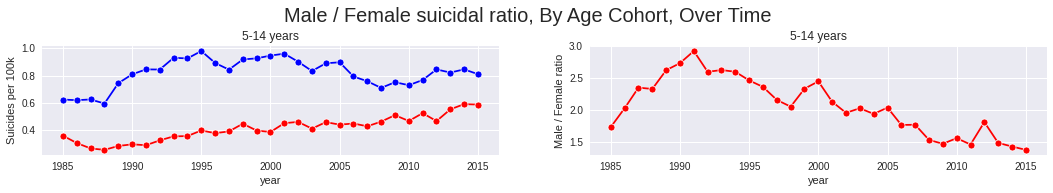

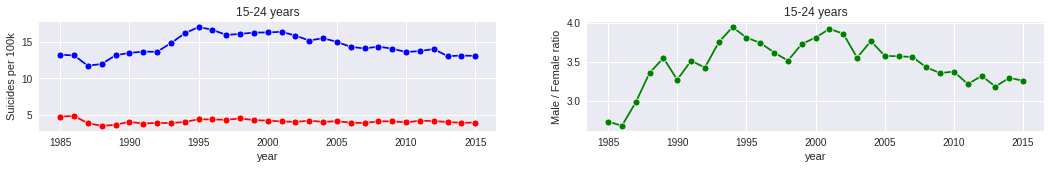

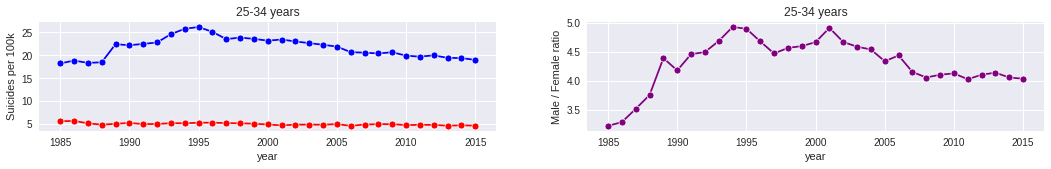

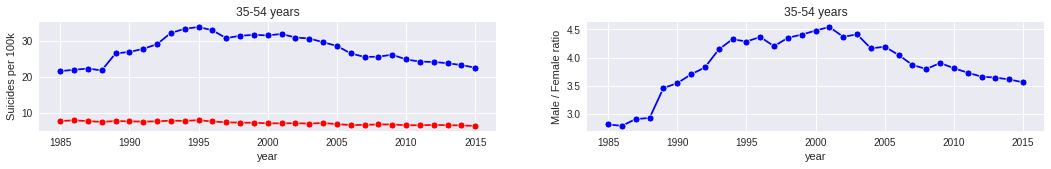

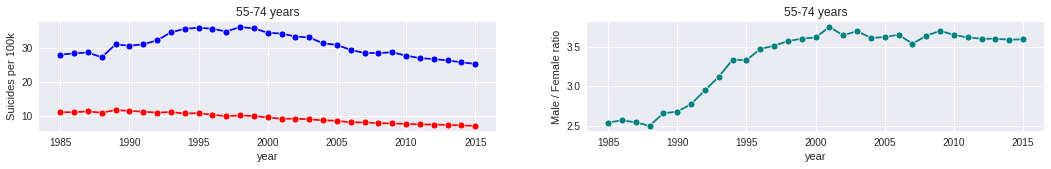

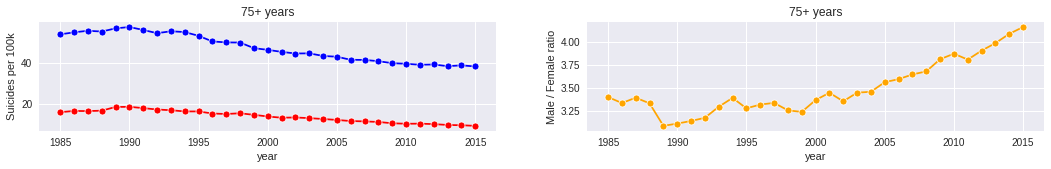

In [39]:
suicide_year_age = suicide_df.groupby(['year','age','sex'])[['population', 'suicides_no']].sum().apply(lambda cont: cont.suicides_no/(cont.population/100000), axis=1).reset_index()
suicide_year_age_sex_ratio = suicide_year_age.groupby(['year', 'age', 'sex']).max().unstack().droplevel(0, axis=1).apply(lambda grp:grp.male / grp.female, axis=1).reset_index()

age_grp = '5-14 years'
suicide_year_age
fig_size = (18,2)
plt.figure(figsize=fig_size)
plt.subplot(1,2,1)
sns.lineplot(data=suicide_year_age.loc[suicide_year_age.age==age_grp], x='year', y=0, marker='o', hue='sex', palette=sex_palette, legend=False)
plt.title(age_grp)
plt.ylabel('Suicides per 100k')
plt.subplot(1,2,2)
sns.lineplot(data=suicide_year_age_sex_ratio.loc[suicide_year_age_sex_ratio.age==age_grp], x='year', y=0, marker='o', hue='age', palette=age_palette, legend=False)
plt.title(age_grp)
plt.ylabel('Male / Female ratio')
plt.suptitle('Male / Female suicidal ratio, By Age Cohort, Over Time', y=1.15, fontsize=20)

for age_grp in ['15-24 years', '25-34 years', '35-54 years', '55-74 years', '75+ years']:
    plt.figure(figsize=fig_size)
    plt.subplot(1,2,1)
    sns.lineplot(data=suicide_year_age.loc[suicide_year_age.age==age_grp], x='year', y=0, marker='o', hue='sex', palette=sex_palette, legend=False)
    plt.title(age_grp)
    plt.ylabel('Suicides per 100k')
    plt.subplot(1,2,2)
    sns.lineplot(data=suicide_year_age_sex_ratio.loc[suicide_year_age_sex_ratio.age==age_grp], x='year', y=0, marker='o', hue='age', palette=age_palette, legend=False)
    plt.title(age_grp)
    plt.ylabel('Male / Female ratio')
plt.show()


***Insights***





* The age cohort for **75+** shows a steady **increase** in male/female suicide ratio from 1989 **(~3.1)** till 2015 **(~4.1)** a **33% increase**

* Ages 15 - 54, male/female suicide ratio show's a **slight improvment** over time

* Ages 55 - 74 male/female suicide ratio is kept **stagnant** at around** ~3.6x** over time

* Ages 4 - 15 male/female suicide ratio show's the biggest improvement across all age cohorts. from **3.0x** in 1991 to **1.4x** in 2015 a **53% decrease**


## By Country - Question: Which countries have the highest suicide rate? which countries show the best improvement over time?

In [ ]:
# Anex
suicides_by_country =  suicide_df.groupby(['continent','country'])[['population', 'suicides_no']].sum().apply(lambda grp:grp.suicides_no/ (grp.population/100000), axis=1).reset_index('continent').sort_values(0, ascending=True)
suicides_by_country.rename(columns={0:'suicides_per_capita'}, inplace=True)
sns.set(font_scale=0.8)

fig, axes = plt.subplots(figsize=(20, 7))
# plt.figure(figsize=(7,14))
sns.barplot(data=suicides_by_country, y='suicides_per_capita', x=suicides_by_country.index, orient='v', hue='continent', dodge=False, ax=axes, palette=continent_palette)
plt.axhline(suicides_by_country['suicides_per_capita'].mean(), linestyle='--', color='black')
plt.xlabel('Country', fontsize=14)
plt.ylabel('Suicides per 100k', fontsize=14)
plt.title('Suicides per 100k capita, by Country', fontsize=20)
plt.xticks(rotation=90, fontsize=10)
plt.show()

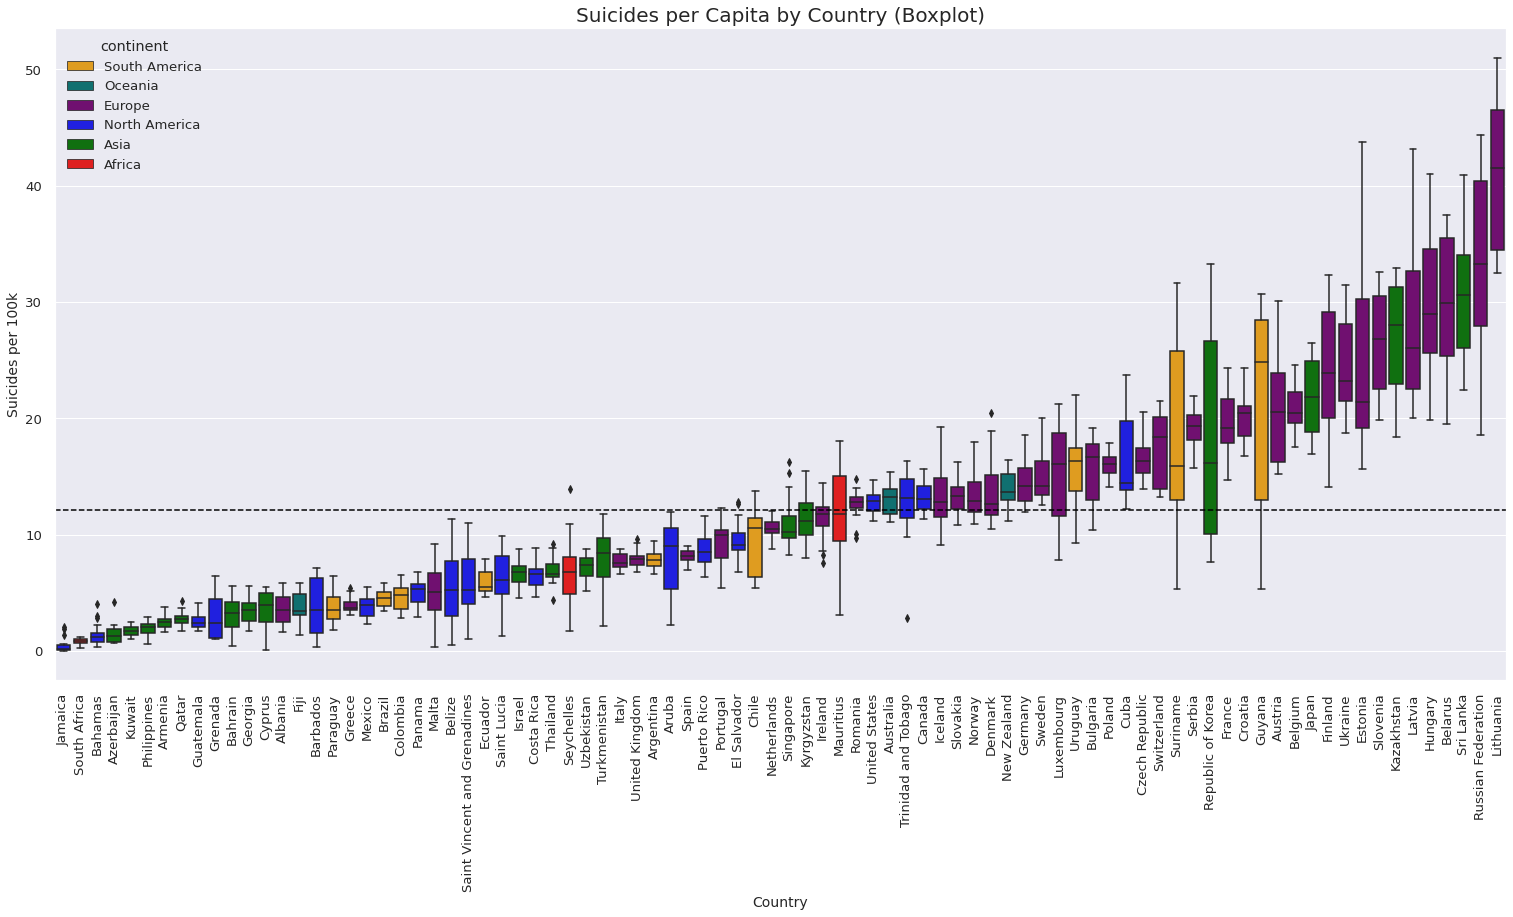

In [41]:
df_country = suicide_df.groupby(['year','country', 'continent'])[['population','suicides_no']].sum().apply(lambda year:year.suicides_no/(year.population/100000), axis=1)\
.to_frame().rename(columns={0:'suicides_per_100k_capita'}).reset_index()

country_ascending_order = suicides_by_country.sort_values('suicides_per_capita', ascending=True).index

sns.set(font_scale=1.2)
plt.figure(figsize=(26,12))
sns.boxplot(data=df_country, y='suicides_per_100k_capita', x='country',order=country_ascending_order, hue='continent', palette=continent_palette, dodge=False)
plt.xticks(rotation=90)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Suicides per 100k', fontsize=14)
plt.title('Suicides per Capita by Country (Boxplot)', fontsize=20)
plt.axhline(suicides_by_country['suicides_per_capita'].mean(), linestyle='--', color='black')

plt.show()


***Insights***

*  **Lithuania** has by far the highest suicidal rate with the **min** suicide of **32.5 per 100k** capita and **max** **of 51 per 100k capita, around 4.2x higher then the average suicide rate of a country**. The Average suicide rate for a country is about **12 per 100k capita**


*  The country with the **highest volatility** in suicides is **republic of korea with ~9 std**. following are: **Guyana,Estonia, Russia, Suriname, Latvia, Lithuania**


---



We now calculate a linear regression between each country's **suicide rate and years**

We want to see in which country, **suicide rate has improved or deteriorated over time.**

We include only countrys with a coefficenet of **pvalue < 0.05**

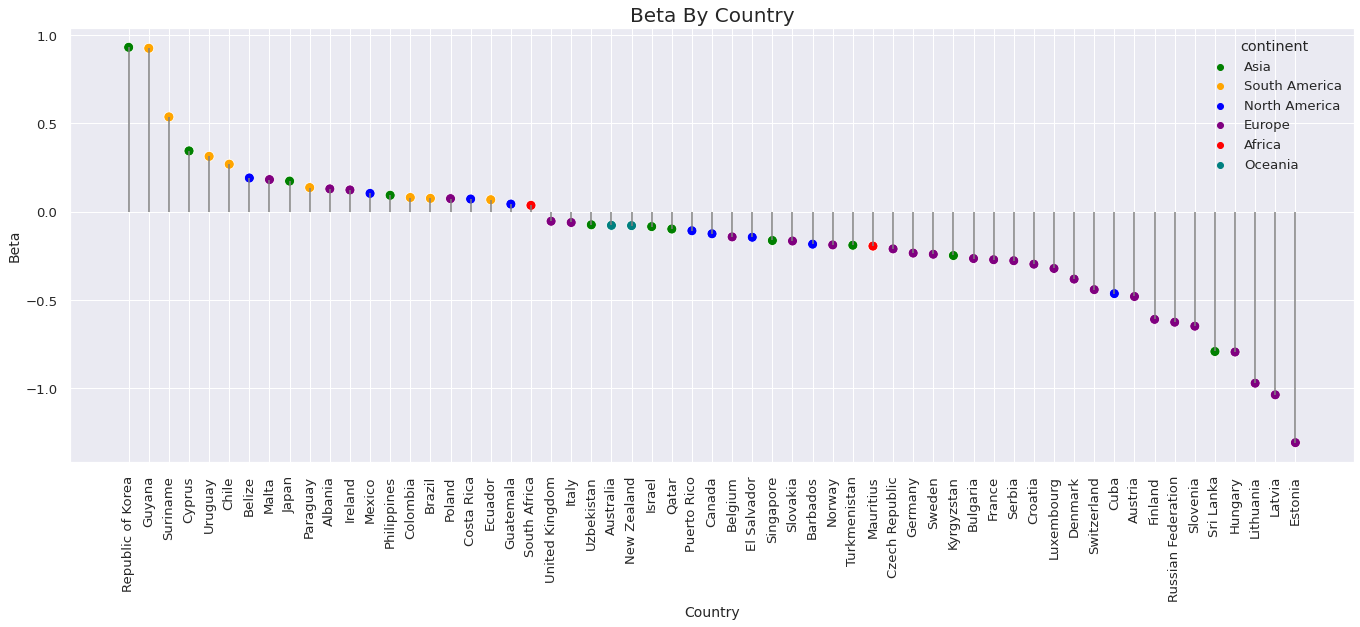

In [42]:
def get_beta(grp):
    reg = linregress(grp.year, grp.suicides_per_100k_capita)
    return reg.slope, reg.pvalue

df_beta_countries = df_country.set_index('country')
df_beta_countries = df_beta_countries.groupby('country').apply(get_beta).sort_values()
df_beta_countries = pd.DataFrame(df_beta_countries.tolist(), index=df_beta_countries.index).rename(columns={0:'beta', 1:'pvalue'})
df_beta_countries = df_beta_countries.loc[df_beta_countries.pvalue<0.05]
# df_beta_countries = df_beta_countries.merge(df_corr, how='inner', left_index=True, right_on='country').set_index('country').rename(columns={'suicides_per_100k_capita':'corr'})
df_beta_countries = df_beta_countries.merge(country_continent_dict, how='inner', left_index=True, right_on='country').sort_values('beta', ascending=False).set_index('country')


plt.figure(figsize=(23,8))
sns.scatterplot(data=df_beta_countries, x=df_beta_countries.index, s=100, y='beta', hue='continent', palette=continent_palette)
# sns.lineplot(data=df_beta_countries, x=df_beta_countries.index, y='corr')
plt.vlines(x=df_beta_countries.index, ymin=df_beta_countries.beta, ymax=0, color='grey')
plt.xticks(rotation=90)
plt.rc('xtick', labelsize=10) 
plt.xlabel('Country', fontsize=14)
plt.ylabel('Beta', fontsize=14)
plt.title('Beta By Country', fontsize=20)
plt.show()





***Insights***

*    **Estonia** shows the **best improvement over time** with a **decrease** of **1.3 suicides per 100k capita** for each year
*    Countries from **Europe** generally **show an improvement in suicide rate over time**
*   **Republic of Korea and Guyana** show the **highest deterioration** with **~0.9 suicides per 100k capita** added each year

###Top 10 Countries with the steepest increase over time 

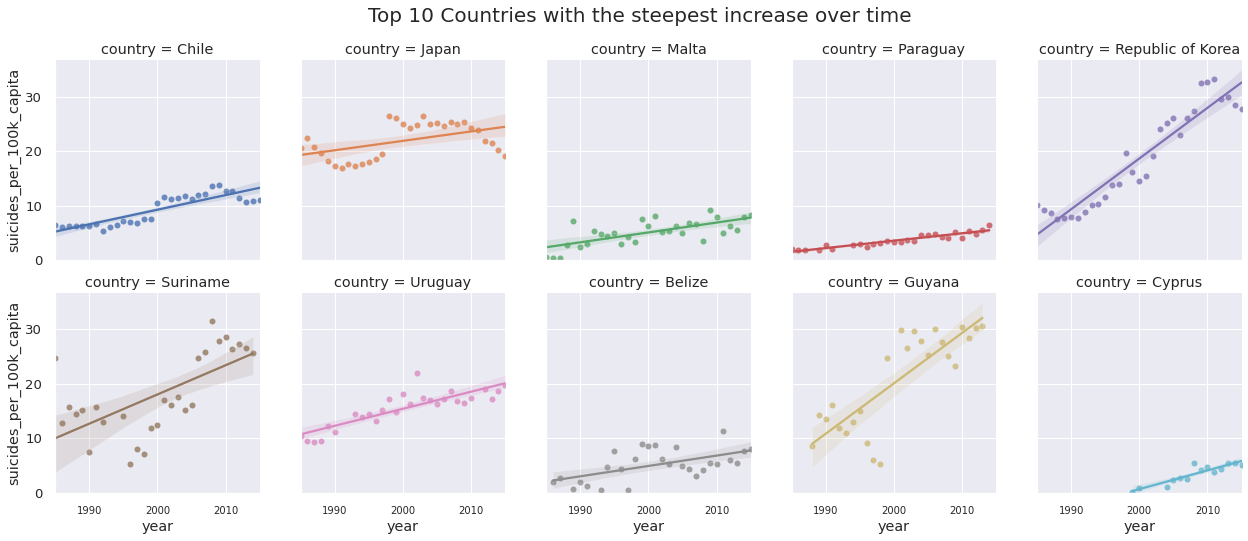

In [43]:
idx_top10 = df_beta_countries.beta.nlargest(10).index
df_top10 = df_country.loc[df_country.country.isin(idx_top10)]
sns.lmplot(data=df_top10, x='year', y='suicides_per_100k_capita', col='country', height=3.5, col_wrap=5, hue='country')
plt.ylim(0)
plt.xticks([1990, 2000, 2010])
plt.suptitle('Top 10 Countries with the steepest increase over time', y=1.04, fontsize=20)
plt.show()

***Insights***



*   **South Korea and Guyana** Shows the most concerning trend, an increase of around **0.93 suicides per 100k, per year.**
*   **Guyana's** suicide rate increased between **1998 and 1999** from **~5 to ~25**, an **increase of around 400%**.
*   The increase in suicide rate in Guyana seems questionable, the jump mentioned earlier seems unlikely and could indicate a change in suicide classification.



###Top 10 Countries with the steepest decrease over time 

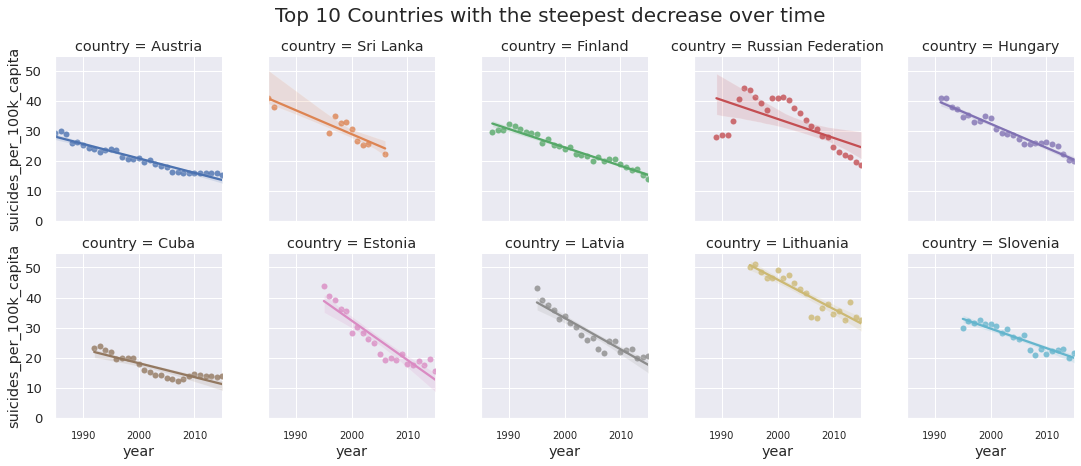

In [44]:
idx_bottom10 = df_beta_countries.beta.nsmallest(10).index
df_bottom10 = df_country.loc[df_country.country.isin(idx_bottom10)]
sns.lmplot(data=df_bottom10, x='year', y='suicides_per_100k_capita', col='country', height=3, col_wrap=5, hue='country')
plt.ylim(0)
plt.xticks([1990, 2000, 2010])
plt.suptitle('Top 10 Countries with the steepest decrease over time', y=1.04, fontsize=20)
plt.show()

***Insights***



*    **Estonia** shows the **best improvement over time** with a **decrease** of **1.3 suicides per 100k capita** for each year
*   Between **1995 and 2015**, suicide rate drops from **43.8 to 15.7 per 100k**- a **64% decrease**
*   The Russian Federation trend starts to drop from 2001 till 2015. an overall **decrease** from **41.4 to 18.6 per 100k - a 55% decrease**



### By Country - More Questions: Is there a country in which more females commit suicides then males?

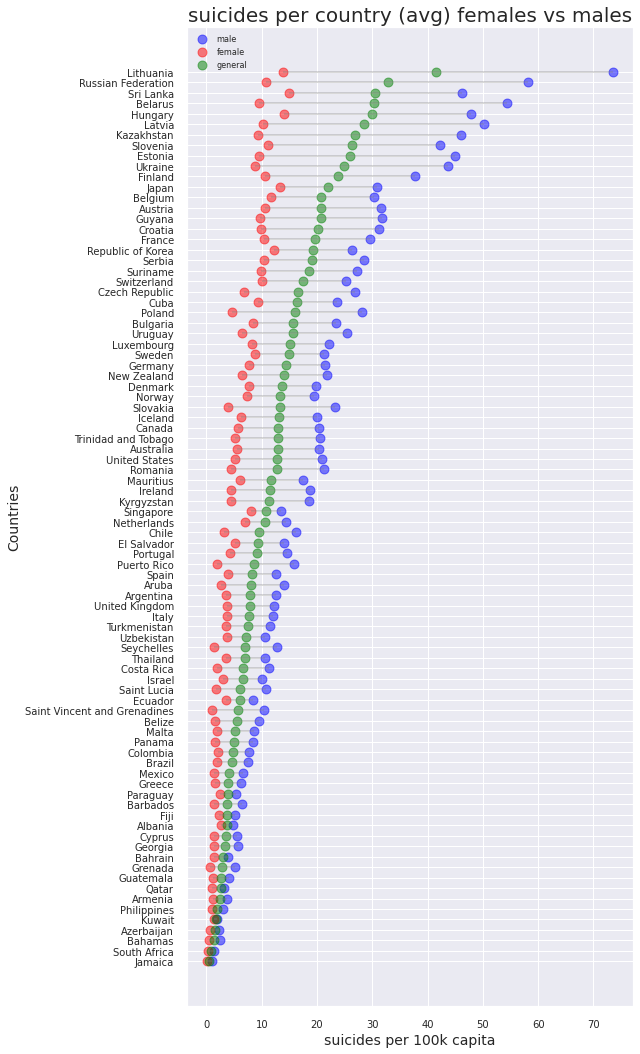

In [45]:
df_country_sex = suicide_df.groupby(['sex','country'])[['population','suicides_no']].sum().apply(lambda year:year.suicides_no/(year.population/100000), axis=1)\
.to_frame().rename(columns={0:'suicides_per_100k_capita'})

plt.figure(figsize=(8,18))
suicides_country_sex = pd.concat([df_country_sex.unstack(0).droplevel(0, axis=1), suicides_by_country],axis=1).sort_values('suicides_per_capita')

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.scatter(x=suicides_country_sex.male,y=suicides_country_sex.index, color='blue', alpha=0.5, label='male', s=80)
plt.scatter(x=suicides_country_sex.female,y=suicides_country_sex.index, color='red',  alpha=0.5, label='female', s=80)
plt.scatter(x=suicides_country_sex.suicides_per_capita,y=suicides_country_sex.index, color='green',  alpha=0.5, label='general', s=80)
plt.hlines(y=suicides_country_sex.index, xmin=suicides_country_sex.female, xmax=suicides_country_sex.male, color='grey', alpha=0.4)
plt.ylabel('Countries', fontsize=14)
plt.xlabel('suicides per 100k capita', fontsize=14)
plt.title('suicides per country (avg) females vs males', fontsize=20)
plt.grid(True)
plt.legend()
plt.show()

***Insights***

*    The case of males commiting more suicides then females is both a global and a domestic issue for each country in our dataset

### Question: Does our data set truly represents the global suicide rate?

Getting data for the interactive *map*:

In [46]:
world_countries = gpd.read_file('https://raw.githubusercontent.com/danihello/suicides_eda/main/custom.geo.json')
world_countries = world_countries.loc[:,['name', 'name_long','geometry']]
geo_suicides = world_countries.merge(suicides_by_country, how='left', left_on='name_long', right_index=True)


Suicides per 100k capita heatmap

In [47]:
m = folium.Map(location=[37, -20], zoom_start=2.4, width='70%', height='75%', min_zoom=2)

import branca
import branca.colormap as cm


folium.Choropleth(
    geo_data=geo_suicides,
    data=geo_suicides,
    columns=['name', 'suicides_per_capita'],
    key_on="feature.properties.name",
    bins=5,
    fill_color='Reds',
    fill_opacity=0.8,
    line_weight=2,
    highlight=True,
    legend_name='suicides per 100k capita'
).add_to(m)


style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.0, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    geo_suicides,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=["name", "suicides_per_capita"],
        aliases=['Country: ','suicides per 100k capita '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") ,
        localize=True
    )
)
m.add_child(NIL)
m.keep_in_front(NIL)
folium.LayerControl().add_to(m)

m

***Insights***



*   I's important to note that looking at the world map figure at a global/ continent level, our data might not truly be representative of the global/ continent suicide rate this is due to lack of data from many countries.
*   Some **key countries are missing** such as: **China, India, most of Africa and many of the middle eastern countries**

*   It is also worth mentioning that **comparing raw suicide rates between different countires may raise some issues**. different countries have different definitation of suicide which may also expalin the large diffrences between countries

*   The **trend over time** within countries however is **likely to be reliable**


## By GDP - Question: Does suicide rate increases if a country is a richer country?

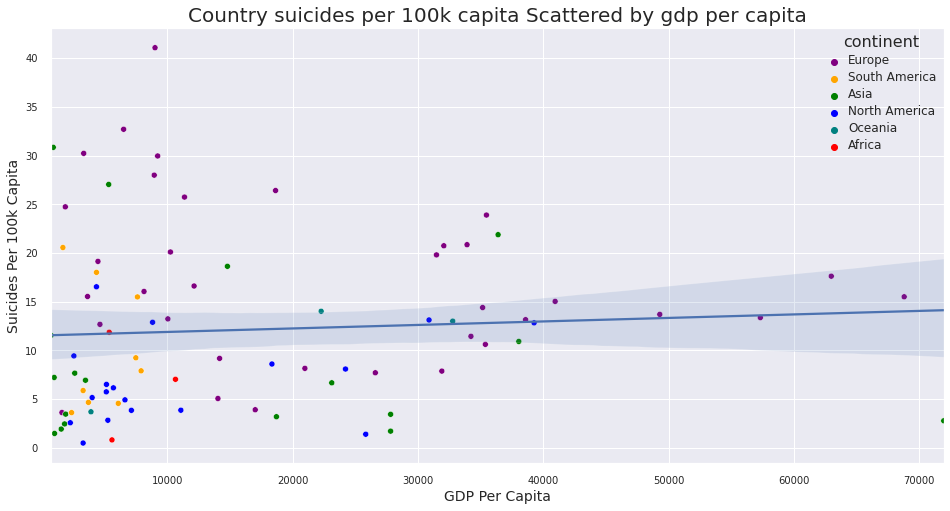

In [48]:
df_country_gdp = suicide_df.groupby(['year','country', 'continent','gdp_per_capita'])[['population','suicides_no']].sum().apply(lambda year:year.suicides_no/(year.population/100000), axis=1)\
.to_frame().rename(columns={0:'suicides_per_100k_capita'}).reset_index()

df_gdp = df_country_gdp.groupby(['country', 'continent'])[['gdp_per_capita','suicides_per_100k_capita']].mean().reset_index()
plt.figure(figsize=(16,8))
ax = sns.scatterplot(data=df_gdp, x='gdp_per_capita', y='suicides_per_100k_capita', hue='continent', palette=continent_palette)
sns.regplot(data=df_gdp, x='gdp_per_capita', y='suicides_per_100k_capita',fit_reg=True,ci=95, scatter=False)
plt.xlabel('GDP Per Capita', fontsize=14)
plt.ylabel('Suicides Per 100k Capita', fontsize=14)
plt.title('Country suicides per 100k capita Scattered by gdp per capita',fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title
plt.show()

In [49]:
linregress(df_gdp.gdp_per_capita, df_gdp.suicides_per_100k_capita)

LinregressResult(slope=3.601062280385645e-05, intercept=11.541103700234125, rvalue=0.0686357501055951, pvalue=0.5300504824640386, stderr=5.7110404540043954e-05)

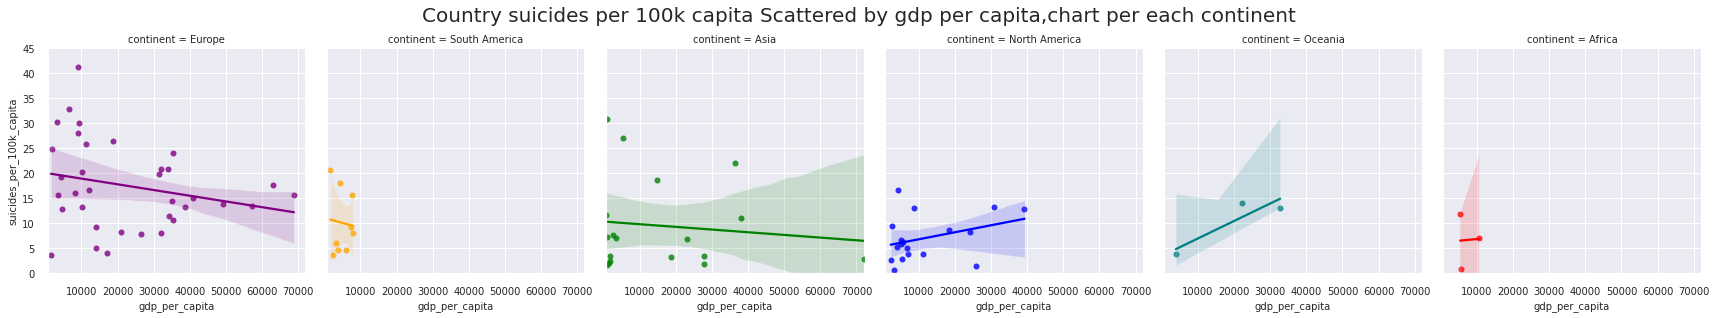

In [50]:
# plt.figure(figsize=(16,8))
sns.lmplot(data=df_gdp, x='gdp_per_capita', y='suicides_per_100k_capita',col='continent' ,hue='continent', palette=continent_palette, height=4)
# sns.regplot(data=df_gdp, x='gdp_per_capita', y='suicides_per_100k_capita',fit_reg=True,ci=95, scatter=False)
plt.ylim(0,45)
plt.suptitle('Country suicides per 100k capita Scattered by gdp per capita,chart per each continent', y=1.05, fontsize=20)
plt.show()

In [51]:
df_country_gdp_reg = df_gdp.groupby('continent').apply(lambda grp:linregress(grp.gdp_per_capita,grp.suicides_per_100k_capita))
pd.DataFrame(df_gdp.groupby('continent').apply(lambda grp:linregress(grp.gdp_per_capita,grp.suicides_per_100k_capita)).tolist(),index=df_country_gdp_reg.index)

,slope,intercept,rvalue,pvalue,stderr
continent,,,,,
Africa,0.00,6.10,0.04,0.98,0.00
Asia,-0.00,10.27,-0.11,0.65,0.00
Europe,-0.00,20.00,-0.24,0.17,0.00
North America,0.00,5.32,0.34,0.16,0.00
Oceania,0.00,3.38,0.90,0.29,0.00
South America,-0.00,10.98,-0.07,0.85,0.00


***Insights***



*   We **did not find a significant effect** of an **increase** in **GDP per capita** on the **suicide rate** not on a global scale and not per any one continent.
*   The GDP per capita is on a scale of ten thousands so **an increase in 1 dollar of GDP per capita would likely not effect suicide rate but how about an increase in 1% of GDP per capita?**




### Question: Does suicide rate increases if a country is a richer country part 2?

This time we analyze using the natural log of GDP per capita

In [52]:
df_gdp['ln_gdp_per_capita'] = np.log(df_gdp.gdp_per_capita)

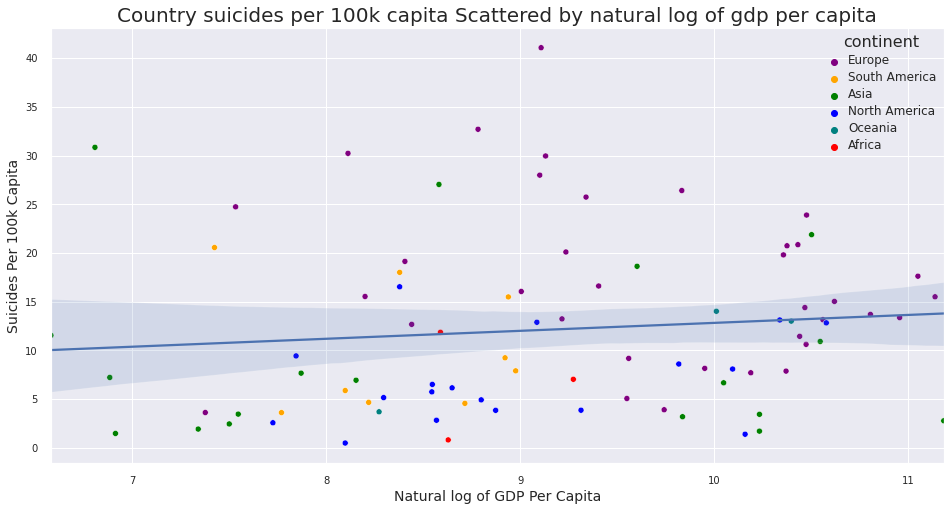

In [53]:
plt.figure(figsize=(16,8))
ax = sns.scatterplot(data=df_gdp, x='ln_gdp_per_capita', y='suicides_per_100k_capita', hue='continent', palette=continent_palette)
sns.regplot(data=df_gdp, x='ln_gdp_per_capita', y='suicides_per_100k_capita',fit_reg=True,ci=95, scatter=False)
plt.xlabel('Natural log of GDP Per Capita', fontsize=14)
plt.ylabel('Suicides Per 100k Capita', fontsize=14)
plt.title('Country suicides per 100k capita Scattered by natural log of gdp per capita',fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title
plt.show()

In [54]:
linregress(df_gdp.ln_gdp_per_capita, df_gdp.suicides_per_100k_capita)

LinregressResult(slope=0.8154247654747551, intercept=4.678408429765018, rvalue=0.107542623127568, pvalue=0.3243404519852514, stderr=0.822503197999189)

<Figure size 1152x576 with 0 Axes>

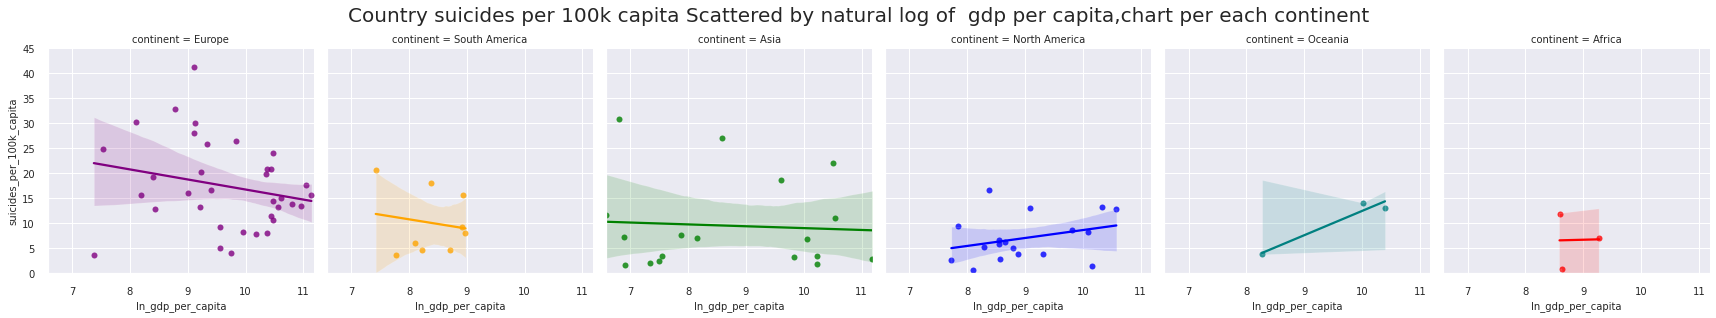

In [55]:
plt.figure(figsize=(16,8))
ax = sns.lmplot(data=df_gdp, x='ln_gdp_per_capita', y='suicides_per_100k_capita',col='continent' ,hue='continent', palette=continent_palette, height=4)
plt.ylim(0,45)
plt.suptitle('Country suicides per 100k capita Scattered by natural log of  gdp per capita,chart per each continent', y=1.05, fontsize=20)
plt.show()

In [56]:
df_country_gdp_reg_ln = df_gdp.groupby('continent').apply(lambda grp:linregress(grp.ln_gdp_per_capita,grp.suicides_per_100k_capita))
pd.DataFrame(df_country_gdp_reg_ln.tolist(),index=df_country_gdp_reg.index)

,slope,intercept,rvalue,pvalue,stderr
continent,,,,,
Africa,0.30,3.95,0.02,0.99,14.40
Asia,-0.37,12.66,-0.06,0.80,1.46
Europe,-2.01,36.77,-0.23,0.18,1.47
North America,1.59,-7.31,0.31,0.21,1.23
Oceania,4.85,-36.15,0.97,0.17,1.29
South America,-1.86,25.63,-0.16,0.68,4.29


***Insights***


* **We did not find a significant effect** of an **increase in 1% of GDP per capita** on the **suicide rate** not on a global scale and not per any one continent.
